In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os.path as path

## Data Preparation

Let's start by reading the data with Pandas from csv.

In [2]:
population = pd.read_csv('studentGrades.csv', sep=';')

In [3]:
population.shape

(1044, 35)

The shape of the data tells us that these dataset contains 1044 samples and 35 variables. Let's take a look at the first 5 entries in the dataset to make sure data has been read correctly.

In [4]:
population.head()

,ID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,1,GP,F,15,U,LE3,A,3,3,other,...,3,4,4,4,1,6,10,13,13,math
1,2,GP,M,16,U,GT3,T,0,2,other,...,3,2,2,4,5,0,11,12,11,port
2,3,GP,M,17,U,GT3,T,3,3,services,...,3,4,2,3,4,12,12,12,11,math
3,4,GP,M,15,U,LE3,T,4,2,teacher,...,5,2,1,1,3,10,18,17,18,port
4,5,GP,M,18,U,LE3,T,2,2,other,...,5,5,2,4,5,2,9,8,8,math


## Data exploration
In this section, using descriptive statistics and graphical displays I will explore some properties of the students dataset including distribution of variables and variables correlation. 

Below I define a function `describe()` that returns basic variable statistics. I am using this function multiple time in this project.

In [5]:
def describe(variable, isSample = False):
    ddof = 1 if isSample else 0
    var_stats = variable.describe()
    var_stats['std'] = variable.std(ddof=ddof)
    var_stats['mode'] = stats.mode(variable)[0][0]
    var_stats['median'] = variable.median()
    var_stats['skew'] = stats.skew(variable)
    var_stats['kurtosis'] = stats.kurtosis(variable, fisher=True) # 3 is substracted by scipy
    return var_stats;

### Final grade distribution
Let's start by exploring the variable of the most interest - final grade **G3**. Exhibit below displays a histogram and boxplot for **G3**.

(array([ 53.,   1.,   0.,   0.,   1.,   8.,  18.,  19.,  67.,  63., 153.,
        151., 103., 113.,  90.,  82.,  52.,  35.,  27.,   8.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

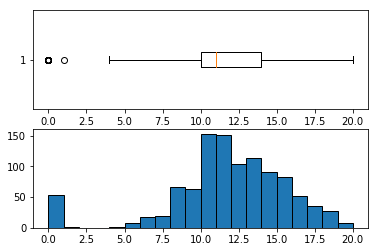

In [6]:
fig, axs = plt.subplots(2, 1, tight_layout=False)
axs[0].boxplot(population['G3'], vert=False)
axs[1].hist(population['G3'], bins=20, edgecolor='black', linewidth=1)

Now, let's calculate descriptive statistics for **G3**

In [7]:
describe(population['G3'])

count       1044.000000
mean          11.341954
std            3.862944
min            0.000000
25%           10.000000
50%           11.000000
75%           14.000000
max           20.000000
mode          10.000000
median        11.000000
skew          -0.984547
kurtosis       1.730235
Name: G3, dtype: float64

It is a bimodal distribution with 2 modes 0 and 10. The distribution has a slightly fat right tale and considering that $mode < median < mean$ this distribution is right skewed. Interesting to notice that skew coefficient is negative that should mean the distribution is left skewed. However, there is an explanation to it - Pearson skeweness coeficient can't be used on non-unimodal distributions.

Let's take a closer look at few samples when **G3** is 0.

In [8]:
population[population['G3'] == 0].head(12)

,ID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
17,18,GP,M,17,R,LE3,T,2,1,at_home,...,3,2,2,2,5,0,7,6,0,math
45,46,GP,M,15,R,GT3,T,3,4,at_home,...,3,3,1,1,5,0,9,0,0,math
62,63,GP,F,16,U,GT3,T,1,3,at_home,...,3,5,1,1,3,0,8,7,0,math
69,70,GP,F,16,U,GT3,A,3,3,other,...,3,2,1,1,5,0,4,0,0,math
97,98,MS,F,19,U,GT3,T,1,1,at_home,...,5,5,2,3,2,0,5,0,0,port
139,140,GP,F,15,R,GT3,T,3,4,services,...,2,2,2,2,5,0,12,0,0,math
150,151,GP,F,18,U,GT3,T,2,2,at_home,...,3,3,1,1,3,0,9,10,0,math
168,169,MS,F,19,R,GT3,T,2,3,services,...,4,2,1,2,5,0,7,5,0,math
172,173,GP,M,19,U,GT3,T,3,2,services,...,5,4,1,1,4,0,5,0,0,math
190,191,MS,F,18,R,GT3,T,2,2,at_home,...,3,3,1,1,4,0,9,0,0,port


Looks like these students didn't do well on the course (grades for term 1 **G1** and term 2 **G2** are mostly lower than median of 11) and decided to drop/withdraw from the course to avoid low grade. We can consider this students as outliers and treat them as a separate category. It might be usefull to investigate what could affect students decision to drop the class. 

Let's remove the outliers and calculate statistics again.

(array([  1.,   0.,   0.,   1.,   8.,  18.,  19.,  67.,  63., 153., 151.,
        103., 113.,  90.,  82.,  52.,  35.,  27.,   7.,   1.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <a list of 20 Patch objects>)

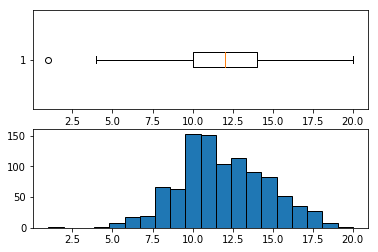

In [9]:
G3_no_drops = population[population['G3'] > 0]['G3']

fig, axs = plt.subplots(2, 1, tight_layout=False)
axs[0].boxplot(G3_no_drops, vert=False)
axs[1].hist(G3_no_drops, bins=20, edgecolor='black', linewidth=1)


In [10]:
describe(G3_no_drops)

count       991.000000
mean         11.948537
std           2.910778
min           1.000000
25%          10.000000
50%          12.000000
75%          14.000000
max          20.000000
mode         10.000000
median       12.000000
skew          0.105460
kurtosis     -0.221284
Name: G3, dtype: float64

After removing outliers the distribution appears to be normal unimodal and has a right skewed shape. This is confirmed by skewness coefficient that is bigger than 0 and the fact that mode < median.

Mode of 10 means that most of the students get grade 10, median of 12 means that 50% of the students get grade lower than or equal to 12, and 50% of the students got grade greater or equal to 12. The right skewness of the distriution suggests that the number of students who got grade higher than mode is bigger than the number of students who got grade lower than 10.

### Age distribution

(array([194., 281., 277., 222.,  56.,   9.,   3.,   2.]),
 array([15.   , 15.875, 16.75 , 17.625, 18.5  , 19.375, 20.25 , 21.125,
        22.   ]),
 <a list of 8 Patch objects>)

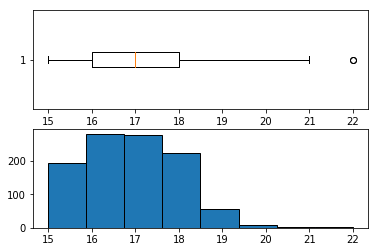

In [11]:
fig, axs = plt.subplots(2, 1, tight_layout=False)
axs[0].boxplot(population['age'], vert=False)
axs[1].hist(population['age'], bins=8, edgecolor='black', linewidth=1)

In [12]:
describe(population['age'])

count       1044.000000
mean          16.726054
std            1.239381
min           15.000000
25%           16.000000
50%           17.000000
75%           18.000000
max           22.000000
mode          16.000000
median        17.000000
skew           0.433405
kurtosis       0.030857
Name: age, dtype: float64

The age is normally distributed, and has a right skewed shape with some outliers that is confirmed by the skeweness coefficient that is greater than 0. Min age of the students is 15 and max age is 22 with the median of 17. Scipy module  allows to conduct a skewness t-test by using `skewtest` function. This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [13]:
t, pvalue = stats.skewtest(population['age'])
print("p-value = %2.8f" % pvalue)

p-value = 0.00000003


p-value < 0.05 so we reject the null hypothesis. This confirms that age distribution is skewed and because skewness coefficient is > 0 it is skewed to the right.

### Correlation between age and final grade
Let's take a look if there is any correlation between the student's age and final grade.

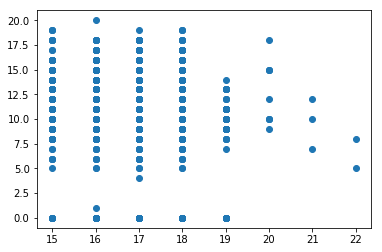

In [14]:
plt.scatter(population['age'], population['G3'])

And let's calculate correlation coefficient. Both variables are normally distributed so we can use Pearson correlation.

In [15]:
r, p_value = stats.pearsonr(population['age'], population['G3'])
print("r = %8.4f" % r)
print("p-value = %8.9f" % p_value)

r =  -0.1253
p-value = 0.000049251


The null hypothesis for `stats.pearsonr` is that there is no correlation. $ p value < 0.05$ means that we reject the null hypothesis and there is an evidence to suggest that there is a correlation at 5% significance level. Looking at the coefficient itself $r < 0$ and $|r|$ is small that indicates that there is **weak negative correlation** between student's age and grade. 

### Correlation between school and final grade
Let's see if strudents' grades in one school are better than in the other. I will start with examining the distribution of students per school.

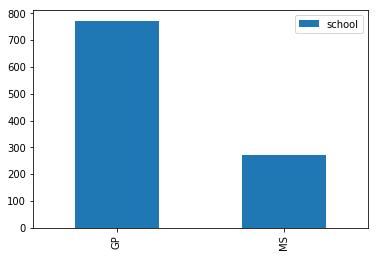

In [16]:
rows_per_school = pd.DataFrame(population['school'].value_counts())
rows_per_school.plot.bar()

Number of students who take Portuguese and Math classes in Gabriel Pereira school is much higher than in Mousinho da Silveira.

Now, let's create a boxplot and calculate basic statistics to see if there is a correlation between school and a grade.

[Text(0,0,'GP'), Text(0,0,'MS')]

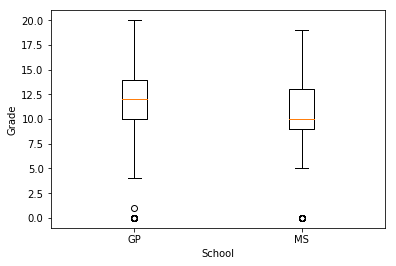

In [17]:
GP_school = population[population['school'] == "GP"]
MS_school = population[population['school'] == "MS"]

fig, axes = plt.subplots(1,1)
axes.boxplot([GP_school['G3'], MS_school['G3']])
axes.set_xlabel("School")
axes.set_ylabel("Grade")
axes.set_xticklabels(["GP", "MS"])

In [18]:
describe(GP_school['G3'])

count       772.000000
mean         11.633420
std           3.806740
min           0.000000
25%          10.000000
50%          12.000000
75%          14.000000
max          20.000000
mode         11.000000
median       12.000000
skew         -1.072203
kurtosis      1.960290
Name: G3, dtype: float64

In [19]:
describe(MS_school['G3'])

count       272.000000
mean         10.514706
std           3.901330
min           0.000000
25%           9.000000
50%          10.000000
75%          13.000000
max          19.000000
mode         10.000000
median       10.000000
skew         -0.802515
kurtosis      1.491535
Name: G3, dtype: float64

Based on the boxplots and the quantiles there seems to be a weak correlation between a school and the grade. Grades in Gabriel Pereira might be higher than grades in Mousinho da Silveira. To know for sure we would need to conduct a 2 sample hypothesis test.

### Correlation between school, subject, and final grade

Let's examine if there is a correlation between school, subject, and grade.

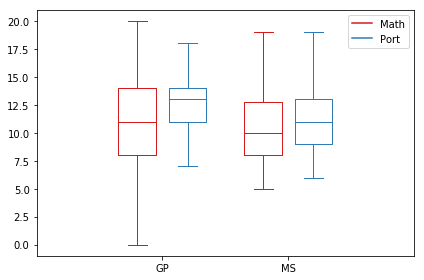

In [20]:
GP_school = population[population['school'] == "GP"]
MS_school = population[population['school'] == "MS"]

math_grades = [GP_school[GP_school['subject'] == "math"]['G3'].values,
              MS_school[MS_school['subject'] == "math"]['G3'].values]

port_grades = [GP_school[GP_school['subject'] == "port"]['G3'].values,
              MS_school[MS_school['subject'] == "port"]['G3'].values]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
ticks = ['GP', 'MS']

plt.figure()

bpl = plt.boxplot(math_grades, positions=np.array(range(len(math_grades)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(port_grades, positions=np.array(range(len(port_grades)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C')
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='Math')
plt.plot([], c='#2C7BB6', label='Port')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

Based on these boxplots we cannot say definitively but it looks like grades that students get in Math class in both schools is about the same. However, it seems like grades in Portuguese class in GP are better than in MS. To check this statement we would need to run a 2 sample hypothesis test.

### Absences distribution

Let's check the distribution of the absences variable.

{'whiskers': [<matplotlib.lines.Line2D at 0x1ac52c7afd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ac52c87860>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ac52c7aac8>],
 'medians': [<matplotlib.lines.Line2D at 0x1ac52c87d68>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ac52c90518>],
 'means': []}

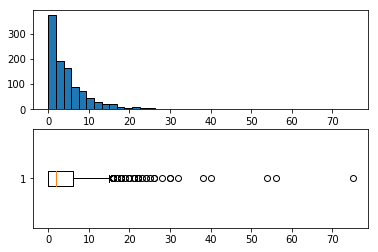

In [21]:
fig, axs = plt.subplots(2, 1, tight_layout=False)
axs[0].hist(population['absences'], bins=40, edgecolor='black', linewidth=1)
axs[1].boxplot(population['absences'], vert=False)

In [22]:
describe(population['absences'])

count       1044.000000
mean           4.434866
std            6.207042
min            0.000000
25%            0.000000
50%            2.000000
75%            6.000000
max           75.000000
mode           0.000000
median         2.000000
skew           3.735969
kurtosis      26.463253
Name: absences, dtype: float64

Absences distribution is right skewed with a few extreme outliers that is indicated by 3 factors: shape of the histogram, skewness coefficient > 0, and mode < median < mean. This means that most of the students do not miss school or miss only a few days that is expected.

### Correlation between final grade and absences

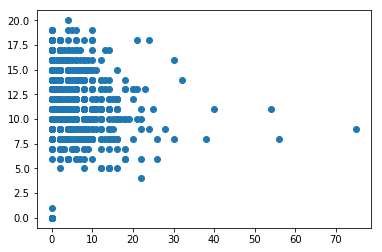

In [23]:
plt.scatter(population['absences'], population['G3'])

Absences variable is not normally distributed so we cannot use Pearson correlation that only works on normally distributed variables. However, Spearman coefficient doesn't make this assumption so we can use it to determine if there is a correlation.

In [24]:
r, p_value = stats.spearmanr(population['absences'], population['G3'])
print("r = %8.4f" % r)
print("p-value = %8.10f" % p_value)

r =  -0.1090
p-value = 0.0004198276


Null hypothesis for `stats.spearmanr` is that there is no correlation between variables. $pvalue < 0.05$ indicates that we reject the null hypothesis and there is evidence to suggest that there is a correlation between final grade and absences. $r<0$ and $|r|$ is small suggests that there is **weak negative correlation**. Students who skip school more often tend to get lower grades than students who don't.

### Compare male and female students by class

Let's compare counts of male and female students by class. Is there a correlation between class and sex?

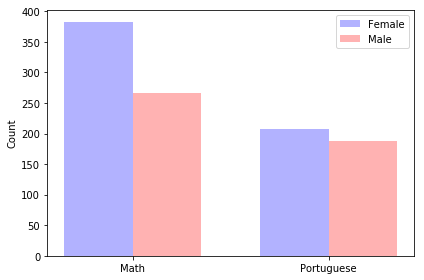

In [25]:
counts_f = population[population['sex'] == "F"]["subject"].value_counts().values
counts_m = population[population['sex'] == "M"]["subject"].value_counts().values

index = np.arange(2)
bar_width = 0.35
opacity = 0.3
 
rects1 = plt.bar(index, counts_f, bar_width,
                 alpha=opacity,
                 color='blue',
                 label='Female')
 
rects2 = plt.bar(index+bar_width, counts_m, bar_width,
                 alpha=opacity,
                 color='red',
                 label='Male')
 
plt.ylabel('Count')
plt.xticks(index + 0.5*bar_width, ('Math', 'Portuguese'))
plt.legend()
 
plt.tight_layout()
plt.show()

This chart tells that there are more female students in Math and Portugese classes than male students. It looks like there are more females in this dataset than males.

## Confidence Intervals

In this section I am goind to construct a few confidence intervals. First, let's create a sample of 95 records and save it as a separate file. I implemented a function `get_sample()` that will return a saved sample if file exists or generate new sample and save it in "data/sample.csv" file.

In [26]:
sample_file = 'data/sample.csv'

def get_sample(sample_file, n=95):
    if path.isfile(sample_file):
        print('Reading sample from the file.')
        sample = pd.read_csv(sample_file)
        return sample
    print('Generating new sample.')
    sample = population.sample(n)
    sample.to_csv(sample_file)
    return sample

sample = get_sample(sample_file)
print('Here is a first 5 records from the sample:')
sample.head()

Reading sample from the file.
Here is a first 5 records from the sample:


,Unnamed: 0,ID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,496,497,GP,F,18,U,GT3,T,1,1,...,4,4,1,1,4,0,12,13,13,port
1,786,787,GP,M,17,R,GT3,T,2,1,...,4,2,2,4,5,0,12,12,13,port
2,197,198,GP,M,19,U,LE3,A,4,3,...,3,1,1,1,1,4,11,13,14,port
3,933,934,GP,F,15,R,GT3,T,1,1,...,1,2,1,1,1,2,7,10,10,math
4,609,610,GP,M,16,U,GT3,T,1,3,...,3,3,1,4,2,2,9,8,8,port


Here I define some helper functions to draw distributions with mean and confidence interval.

In [27]:
def plot_ci_t(x_bar, s, df, n, ci_low, ci_high, mu, x_min=0.05, x_max=0.95):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(x_bar+stats.t.ppf(x_min, df), x_bar+stats.t.ppf(x_max, df), 1000)
    ax.plot(x, stats.t.pdf((x-x_bar)*math.sqrt(n)/s, df))
    
    ax.axvline(x=ci_low, color="red", lw=1)
    ax.axvline(x=ci_high, color="red", lw=1)
    ax.axvline(x=x_bar, color="green", linestyle="--", lw=1, label='x_bar')
    ax.plot([mu], [0], marker='o', markersize=3, linestyle="", color="black", label="mu")
    ax.legend(loc='best')

def plot_ci_p(p, n, ci_low, ci_high, mu, x_min=0.05, x_max=0.95):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(p+stats.norm.ppf(x_min), p+stats.norm.ppf(x_max), 1000)
    ax.plot(x, stats.norm.pdf((x-p)*math.sqrt(n/(p*(1-p)))))
    
    ax.axvline(x=ci_low, color="red", lw=1)
    ax.axvline(x=ci_high, color="red", lw=1)
    ax.axvline(x=p, color="green", linestyle="--", lw=1, label='p_hat')
    ax.plot([mu], [0], marker='o', markersize=3, linestyle="", color="black", label="p")
    ax.legend(loc='best')

### 1. A 90% confidence interval for the age of the students

I am constructing a 90% confidence interval for the mean student age. Considering that population standard deviation $\sigma$ is unknown I should use a t-distribution. Confidence interval is calculated by the formula $$\bar{x} \pm t_{\alpha/2}(\frac{s}{\sqrt{n}}), \space\space n > 30 \space\space\text{(1)}$$.

Let's calculate sample mean, sample standart deviation, and critical value $t_{\alpha/2}$. I am going to use function `describe()` defined in the begining of the document with paramenter `isSample=True`.

In [28]:
age_stats = describe(sample['age'], isSample=True)

x_bar = age_stats['mean']
s = age_stats['std']
alpha = 0.1
n = sample.shape[0]
df = n - 1
t_alpha_2 = stats.t.ppf(alpha/2, df)

print("x_bar = %2.4f" % round(x_bar,4))
print("s = %2.4f" % round(s,4))
print("alpha = %2.2f" % alpha)
print("n = %d" % n)
print("df = %d" % df)
print("t_alpha_2 = %2.4f" % round(t_alpha_2,4))

x_bar = 16.6526
s = 1.2613
alpha = 0.10
n = 95
df = 94
t_alpha_2 = -1.6612


Now, I can calculate margin of error and confidence interval using formula (1).

In [29]:
margin_error = abs(t_alpha_2 * s / math.sqrt(n))
ci_low = x_bar - margin_error
ci_high = x_bar + margin_error

print("Margin of error is %2.4f" % round(margin_error,4))
print("Confidence interval is (%2.4f, %2.4f)" % (round(ci_low,4), round(ci_high,4)))

Margin of error is 0.2150
Confidence interval is (16.4377, 16.8676)


We are 90% confident that the true mean of the student age in math and Portuguese language courses in a secondary school is between 16.4377 and 16.8676.

Now let's check if the actual population mean lies in this interval.

Population mean = 16.7261


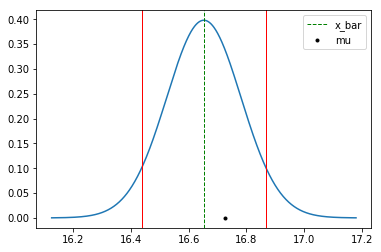

In [30]:
age_pop_stats = describe(population['age'])
mean = age_pop_stats['mean']
print("Population mean = %2.4f" % round(mean,4))

plot_ci_t(x_bar, s, df, n, ci_low, ci_high, mean, 0.3, 0.7)

$16.4377 < 16.7261 < 16.8676$ so the true population mean of age of the students lies within the 90% confidence interval.

### 2.	A 99% confidence interval for the final grade (G3)

Now let's compute the 99% confidence interval for the mean student's grade. We are going to use the same sample. 

We should assume that population standard deviation is unknown so we need to use Student's t distribution with confidence interval calculated by formula (1). Let's calculate G3 statistics need to use the formula.

In [31]:
g3_stats = describe(sample['G3'], isSample=True)

x_bar = g3_stats['mean']
s = g3_stats['std']
alpha = 0.01
n = sample.shape[0]
df = n - 1
t_alpha_2 = stats.t.ppf(alpha/2, df)

print("x_bar = %2.4f" % x_bar)
print("s = %2.4f" % s)
print("alpha = %2.2f" % alpha)
print("n = %d" % n)
print("df = %d" % df)
print("t_alpha_2 = %2.4f" % t_alpha_2)

x_bar = 11.1263
s = 3.9363
alpha = 0.01
n = 95
df = 94
t_alpha_2 = -2.6291


Using the formula (1) we can calculate margin of error and confidence interval.

In [32]:
margin_error = abs(t_alpha_2 * s / math.sqrt(n))
ci_low = x_bar - margin_error
ci_high = x_bar + margin_error

print("Margin of error is %2.4f" % margin_error)
print("Confidence interval is (%2.4f, %2.4f)" % (ci_low, ci_high))

Margin of error is 1.0618
Confidence interval is (10.0645, 12.1881)


We are 99% confident that the true population mean of students final grade falls within (10.0645, 12.1881).

Let's check if this holds for our population mean.

Population mean mu = 11.3420


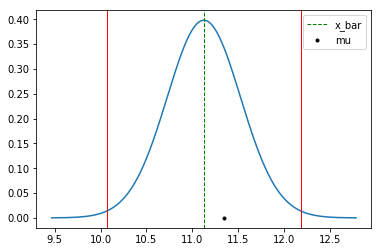

In [33]:
g3_pop_stats = describe(population['G3'])
mean = g3_pop_stats['mean']
print("Population mean mu = %2.4f" % mean)

plot_ci_t(x_bar, s, df, n, ci_low, ci_high, mean)

And we see that true population mean of final grades falls into the 99% confidence interval.

### 3.	A 95% confidence interval for the number of absences students have.

Let's compute the 95% confidence interval for the mean number of absences students have. We are going to use 'absences' variable. As in previous examples we are going to use Student's t distribution and formula (1). 

In [34]:
abs_stats = describe(sample['absences'], isSample=True)

x_bar = abs_stats['mean']
s = abs_stats['std']
alpha = 0.05
n = sample.shape[0]
df = n - 1
t_alpha_2 = stats.t.ppf(alpha/2, df)

print("x_bar = %2.4f" % x_bar)
print("s = %2.4f" % s)
print("alpha = %2.2f" % alpha)
print("n = %d" % n)
print("df = %d" % df)
print("t_alpha_2 = %2.4f" % t_alpha_2)

x_bar = 4.4105
s = 4.8542
alpha = 0.05
n = 95
df = 94
t_alpha_2 = -1.9855


In [35]:
margin_error = abs(t_alpha_2 * s / math.sqrt(n))
ci_low = x_bar - margin_error
ci_high = x_bar + margin_error

print("Margin of error is %2.4f" % margin_error)
print("Confidence interval is (%2.4f, %2.4f)" % (ci_low, ci_high))

Margin of error is 0.9889
Confidence interval is (3.4217, 5.3994)


We are 95% confident that the true mean of student's absences in math and Portuguese language classes is between 3.4217 and 5.3994. Let's check if true population mean falls into this interval in our case.

Population mean = 4.4349


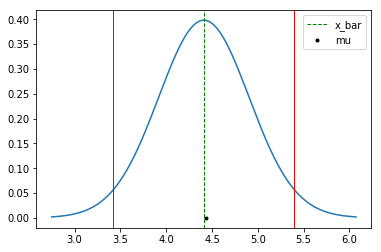

In [37]:
abs_pop_stats = describe(population['absences'])
mean = abs_pop_stats['mean']
print("Population mean = %2.4f" % mean)

plot_ci_t(x_bar,s, df, n, ci_low, ci_high, mean)

In this case true population mean of number of absences that students have falls within the 95% confidence interval.

### 4. Confidence interval of your choise
### 95% confidence interval of proportion of students with family size greater than 3

I am going to use the proportion confidence interval formula.
$$\hat{p} \pm z_{\alpha/2}\sqrt{\frac{\hat{p}(1-\hat{p})}{n}} \space\space\text{(2)} $$

$\hat{p}$ is a sample proportion.

I also need to check normality by checking the following inequations:
$$n_{sample} \leq 0.1 n_{population} \space\space \text{(3)}$$
$$n_{sample}*p \geq 10 \space\space \text{and} \space\space n_{sample}*(1-p) \geq 10 \space\space \text{(4)}$$


Let's start by calculating sample proportion $\hat{p}$.

In [38]:
n = 95
n_gt3 = sample[sample["famsize"] == "GT3"].shape[0]
p_hat = n_gt3/n

print("Number of students with families more than 3 is %d ." % n_gt3)
print("p_hat = %1.4f" % p_hat)

Number of students with families more than 3 is 69 .
p_hat = 0.7263


Let's check the normality conditions.

In [39]:
print("Condition (3): %d < 0.1*%d" % (n, population.shape[0]))
print("Condition (4): n*p = %d, n*(1-p) = %d, both are greater than 10" % (n*p_hat, round(n*(1-p_hat))))

Condition (3): 95 < 0.1*1044
Condition (4): n*p = 69, n*(1-p) = 26, both are greater than 10


Conditions are satisfied. Now I can calculate 95% confidence interval and margin of error using formula (2).

In [40]:
alpha = 0.05
z_alpha_2 = stats.norm.ppf(alpha/2)

print("z_alpha_2 = %1.2f" % round(z_alpha_2, 4))

margin_error = round(abs(z_alpha_2)*math.sqrt(p_hat*(1-p_hat)/n), 4)
ci_low = round(p_hat - margin_error, 4)
ci_high = round(p_hat + margin_error, 4)

print("Margin of error is %2.4f" % round(margin_error, 4))
print("Confidence interval is (%2.4f, %2.4f)" % (round(ci_low,4), round(ci_high,4)))

z_alpha_2 = -1.96
Margin of error is 0.0897
Confidence interval is (0.6366, 0.8160)


We are 95% confident that the true proportion of students who live in a family of more than 3 falls between 63.66% and 81.60%. 

Let's find a population proportion and check if it lies in the 95% confidence interval.

Population proportion p = 70.69%


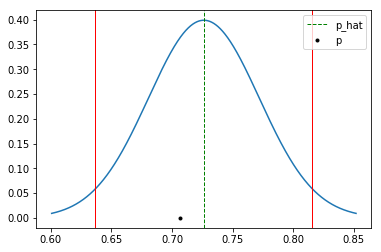

In [41]:
n_pop_gt3 = population[population["famsize"] == "GT3"].shape[0]
p = n_pop_gt3/population.shape[0]
print("Population proportion p = %2.2f%%" % (round(p,4)*100))

plot_ci_p(p_hat, n, ci_low, ci_high, p, x_min=0.45, x_max=0.55)

True population proportion of students with family size greater than 3 falls within the 95% confidence interval.

## Hypothesis Tests

Let's start with defining few helper functions for this section.

`get_stats` - returns basic statistics for the sample

`get_dof` - returns degree of freedom calculated by Welch-Satterthwaite formula

`plot_hypo_t` - plots a distribution with vertical lines for critical values and test statistic

In [42]:
def get_stats(sample):
    n = sample.shape[0]
    mean = sample.mean()
    std = sample.std()
    return n, mean, std

def get_dof(x, y): 
    ## Welch-Satterthwaite degrees of freedom
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof

def plot_hypo_t(x_bar, t, t_alpha, x_min=0.01, x_max=0.99, two_tail=False):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(x_bar+stats.t.ppf(x_min, df), x_bar+stats.t.ppf(x_max, df), 1000)
    ax.plot(x, stats.t.pdf(x, df))
    
    ax.axvline(x=t_alpha, color="red", lw=1, label='Critical Value')
    
    if two_tail :
        ax.axvline(x = -1*t_alpha, color="red", lw=1)

    ax.axvline(x=t, color="green", linestyle="--", lw=1, label='Test Statistic')
    ax.legend(loc='best')

### 1.	Do students whose parents live together (Pstatus) get better grades (alpha = 0.05)?

Let's get 2 samples and calcualte basic statistics.

In [43]:
g3_together = sample[sample['Pstatus'] == 'T']['G3']
g3_apart = sample[sample['Pstatus'] == 'A']['G3']

n_t, x_t, s_t = get_stats(g3_together)
n_a, x_a, s_a = get_stats(g3_apart)

print("Sample statistics for students whose parents live together:")
print("n_t = %d" % n_t)
print("x_bar_t = %4.4f" % x_t)
print("s_t = %4.4f" % s_t)

print("Sample statistics for students whose parents live apart:")
print("n_a = %d" % n_a)
print("x_bar_a = %4.4f" % x_a)
print("s_a = %4.4f" % s_a)

Sample statistics for students whose parents live together:
n_t = 82
x_bar_t = 10.8537
s_t = 4.0096
Sample statistics for students whose parents live apart:
n_a = 13
x_bar_a = 12.8462
s_a = 3.0234


In this sample mean grade of students whose parents live apart is higher than of students whose parents live together so it makes sense to check if students whose parents live apart get better grades.

$H_0: \mu_t - \mu_a = 0$ 

$H_a: \mu_t - \mu_a < 0$

$\alpha = 0.05$

Population standard deviation is assumed to be unknown and to be conservative I assume unequal variance. Then we are going to use Student's t-distribution and calculate the test statistics using following formula:

$$t = \frac{\bar{x_t} - \bar{x_a}}{\sqrt{\frac{s_t^2}{n_t} + \frac{s_a^2}{n_a}}}$$

Degree of freedom is calculated using Welch–Satterthwaite equation.

I am going to use [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to perform the 2 sample t-test assuming unequal variance. Note that `tttest_ind` returns p-value for 2-sided test that needs to be devided by 2 in order to get 1-sided p-value.

In [44]:
t, p = stats.ttest_ind(g3_together, g3_apart, equal_var = False)
print("t = %1.4f" % round(t, 4))
print("p-value 2 tailed = %1.4f" % round(p, 4))
print("p-value = %1.4f" % round(p/2, 4))

t = -2.1012
p-value 2 tailed = 0.0489
p-value = 0.0245


We know the test statistic and p-value, now, let's calculate $t_{\alpha}$ critical value for one sided test. First, I will calculate the degree of freedom and then use it to calculate critical value.

In [45]:
alpha = 0.05
dof = get_dof(g3_together, g3_apart)
t_alpha = stats.t.ppf(alpha, dof)

print("d.f. = %3.4f" % round(dof, 4))
print("t_alpha = %1.4f" % round(t_alpha, 4))

d.f. = 19.4015
t_alpha = -1.7273


Once we know our critical value let's plot a disribution.

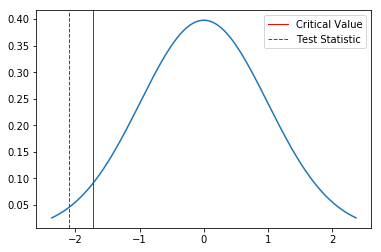

In [46]:
plot_hypo_t(0, t, t_alpha)

Test statistic $t$ falls into the rejection region so we reject the null hypothesis $H_0$. We can also perform the test using p-value, that is $pvalue = 0.0245$ and $0.0245 < \alpha = 0.05$ so we reject the null hypothesis.

We conclude that there is enough evidence to suggest that students whose parents live apart get better grades than student's whose parents live together at 5% significance level. Then the answer to the original question "Do students whose parents live together (Pstatus) get better grades?" is no.

### 2. Do students with internet access get better grades (alpha=0.01)?

Let's create 2 samples for students with and without internet access and calculate basic statistics.

In [47]:
g3_int = sample[sample['internet'] == 'yes']['G3']
g3_noint = sample[sample['internet'] == 'no']['G3']

n_1, x_1, s_1 = get_stats(g3_int)
n_2, x_2, s_2 = get_stats(g3_noint)

print("Sample statistics of grades of students with internet access:")
print("n_1 = %d" % n_1)
print("x_bar_1 = %4.4f" % x_1)
print("s_1 = %4.4f" % s_1)

print("Sample statistics of grades of students without internet access:")
print("n_2 = %d" % n_2)
print("x_bar_2 = %4.4f" % x_2)
print("s_2 = %4.4f" % s_2)

Sample statistics of grades of students with internet access:
n_1 = 74
x_bar_1 = 11.0676
s_1 = 4.1424
Sample statistics of grades of students without internet access:
n_2 = 21
x_bar_2 = 11.3333
s_2 = 3.1833


Sample mean of students without internet access is higher than for students with internet access so it makes sense to perform the hypothesis test whether students without internet access has better grades than students with internet access.

$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 < 0$

$\alpha = 0.01$

I assume that population standard deviation is unknown and that variances are unequal. Samples are independent so we can perform a 2 sample t-test.

$$t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [48]:
t, p = stats.ttest_ind(g3_int, g3_noint, equal_var = False)
print("t = %1.4f" % round(t, 4))
print("p-value 2 tailed = %1.4f" % round(p, 4))
print("p-value = %1.4f" % round(p/2, 4))

t = -0.3144
p-value 2 tailed = 0.7548
p-value = 0.3774


Test statistic $t$ and p-value are known, next, we calculate $t_{\alpha}$ since this is a 1-tailed test.

In [49]:
alpha = 0.01
dof = get_dof(g3_int, g3_noint)
t_alpha = stats.t.ppf(alpha, dof)

print("d.f. = %3.4f" % round(dof, 4))
print("t_alpha = %1.4f" % round(t_alpha, 4))

d.f. = 41.2323
t_alpha = -2.4203


Let's plot the distribution and mark $t$ and $t_{\alpha}$.

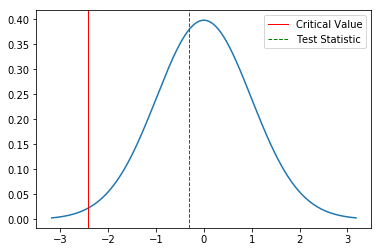

In [50]:
plot_hypo_t(0, t, t_alpha, 0.001, 0.999)

$t_{\alpha} = -1.6827 < t = -0.3144$

and based on the chart test statistic $t$ falls into "fail to reject" region. Also $pvalue=0.3774 > \alpha = 0.01$ that indicates that we cannot reject the null hypothesis.

There is not enough evidence to suggest that students without internet access has better grades than students with internet access.

### 3.	Are the math grades between the two schools different (alpha=0.1)?

First, let's get 2 samples and calculate basic statistics.

In [51]:
math_data = sample[sample['subject'] == 'math']

g3_gp = math_data[math_data['school'] == 'GP']['G3']
g3_ms = math_data[math_data['school'] == 'MS']['G3']

n_1, x_1, s_1 = get_stats(g3_gp)
n_2, x_2, s_2 = get_stats(g3_ms)

print("Sample statistics of Math grades in Gabriel Pereira:")
print("n_1 = %d" % n_1)
print("x_bar_1 = %4.4f" % x_1)
print("s_1 = %4.4f" % s_1)

print("Sample statistics of Math grades in Mousinho da Silveira:")
print("n_2 = %d" % n_2)
print("x_bar_2 = %4.4f" % x_2)
print("s_2 = %4.4f" % s_2)

Sample statistics of Math grades in Gabriel Pereira:
n_1 = 34
x_bar_1 = 9.5882
s_1 = 4.9551
Sample statistics of Math grades in Mousinho da Silveira:
n_2 = 3
x_bar_2 = 12.3333
s_2 = 4.6188


Number of records in the seconds sample is only 3. So I am going to generate a new larger sample n=300 and try again. New sample will be saved as sample_hypo_3.csv.

In [52]:
sample_hypo_3 = get_sample("data/sample_hypo_3.csv", n=300)

Reading sample from the file.


In [53]:
math_data = sample_hypo_3[sample_hypo_3['subject'] == 'math']

g3_gp = math_data[math_data['school'] == 'GP']['G3']
g3_ms = math_data[math_data['school'] == 'MS']['G3']

n_1, x_1, s_1 = get_stats(g3_gp)
n_2, x_2, s_2 = get_stats(g3_ms)

print("Sample statistics of Math grades in Gabriel Pereira:")
print("n_1 = %d" % n_1)
print("x_bar_1 = %4.4f" % x_1)
print("s_1 = %4.4f" % s_1)

print("Sample statistics of Math grades in Mousinho da Silveira:")
print("n_2 = %d" % n_2)
print("x_bar_2 = %4.4f" % x_2)
print("s_2 = %4.4f" % s_2)

Sample statistics of Math grades in Gabriel Pereira:
n_1 = 93
x_bar_1 = 10.7957
s_1 = 4.5434
Sample statistics of Math grades in Mousinho da Silveira:
n_2 = 14
x_bar_2 = 10.3571
s_2 = 4.8295


Since we need to check if the math grades are different we are going to use a 2 tailed test. Also as before assuming that population $\sigma$ is unknown and unequal variance.

$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 \ne 0$

$\alpha = 0.1$

$$t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [54]:
t, p = stats.ttest_ind(g3_gp, g3_ms, equal_var = False)
print("t = %1.4f" % round(t, 4))
print("p-value 2 tailed = %1.4f" % round(p, 4))

t = 0.3192
p-value 2 tailed = 0.7536


Test statistic $t$ and p-value are known, next, we calculate $t_{\alpha/2}$ since this is a 2-tailed test.

In [55]:
alpha = 0.1
dof = get_dof(g3_gp, g3_ms)
t_alpha = stats.t.ppf(alpha/2, dof)

print("d.f. = %3.4f" % round(dof, 4))
print("t_alpha = %1.4f" % round(t_alpha, 4))

d.f. = 16.6530
t_alpha = -1.7417


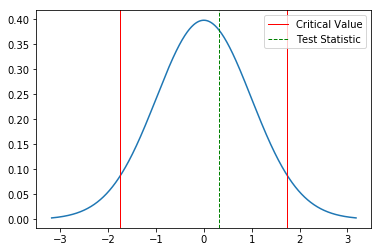

In [56]:
plot_hypo_t(0, t, t_alpha, 0.001, 0.999, True)

Test statistics falls into "Fail to reject" region. Also $pvalue=0.7536 > \alpha=0.1$. So we fail to reject the null hypothesis $H_0$.

We conclude that there is not enough evidence to suggest that there is a difference in math grades between 2 schools at 10% significance level.

### 4. Do students who study more than 5 hours a week get better grades than those who study less at 10% significance level?

Variable studytime indicates a bucket to which studytime of particular studets falls. I am interested in two samples - first with studytime $\leq$ 2 and second where studytime > 2. I am going to use original sample.

In [57]:
g3_less = sample[sample['studytime'] <= 2]['G3']
g3_more = sample[sample['studytime'] > 2]['G3']

n_1, x_1, s_1 = get_stats(g3_less)
n_2, x_2, s_2 = get_stats(g3_more)

print("Sample statistics of grades of students who study less than 5 hours a week:")
print("n_1 = %d" % n_1)
print("x_bar_1 = %4.4f" % x_1)
print("s_1 = %4.4f" % s_1)

print("Sample statistics of grades of students who study more than 5 hours a week:")
print("n_2 = %d" % n_2)
print("x_bar_2 = %4.4f" % x_2)
print("s_2 = %4.4f" % s_2)

Sample statistics of grades of students who study less than 5 hours a week:
n_1 = 74
x_bar_1 = 10.9189
s_1 = 3.8526
Sample statistics of grades of students who study more than 5 hours a week:
n_2 = 21
x_bar_2 = 11.8571
s_2 = 4.2342


Let's conduct a hypothesis test.

$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 < 0$

$\alpha = 0.1$

Samples are independent and I assume that population $\sigma$ is unknown and unequal variance.

$$t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [58]:
t, p = stats.ttest_ind(g3_less, g3_more, equal_var = False)
print("t = %1.4f" % round(t, 4))
print("p-value 2 tailed = %1.4f" % round(p, 4))
print("p-value = %1.4f" % round(p/2, 4))

t = -0.9137
p-value 2 tailed = 0.3681
p-value = 0.1841


Let's find a critical value $t_{\alpha}$ since this is a 1-tailed test.

In [59]:
alpha = 0.1
dof = get_dof(g3_less, g3_more)
t_alpha = stats.t.ppf(alpha, dof)

print("d.f. = %3.4f" % round(dof, 4))
print("t_alpha = %1.4f" % round(t_alpha, 4))

d.f. = 30.0471
t_alpha = -1.3104


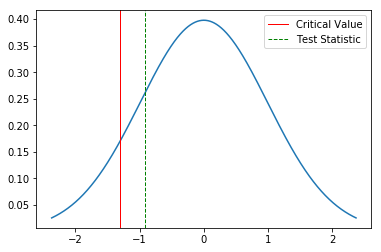

In [60]:
plot_hypo_t(0, t, t_alpha)

$pvalue = 0.1841 > \alpha=0.1$ so we fail to reject the null hypothesis. Also, you can see on plot above that test statistic $t$ falls into the "Do not reject" region.

There is not enough evidence to suggest that students who study more than 5 hours a week get better grades than students who study less than 5 hours a week at 10% significance level.

### 5. Do students who consume alcohol very little regardless of the day of the week get higher grades than others?

Students who consume alcohol very little are those with Dalc = 1 and Walc = 1. Studen't who consumes alcohol more than very little are everyone else, Dals != 1 or Walc != 1. Let's split the sample.

In [61]:
g3_no_alc = sample[ (sample['Dalc'] == 1) & (sample['Walc'] == 1)]['G3']
g3_alc = sample[ (sample['Dalc'] != 1) | (sample['Walc'] != 1)]['G3']

n_1, x_1, s_1 = get_stats(g3_no_alc)
n_2, x_2, s_2 = get_stats(g3_alc)

print("Sample statistics of grades of students who do not consume alcohol:")
print("n_1 = %d" % n_1)
print("x_bar_1 = %4.4f" % x_1)
print("s_1 = %4.4f" % s_1)

print("Sample statistics of grades of students who consumes more than very low alcohol:")
print("n_2 = %d" % n_2)
print("x_bar_2 = %4.4f" % x_2)
print("s_2 = %4.4f" % s_2)

Sample statistics of grades of students who do not consume alcohol:
n_1 = 42
x_bar_1 = 12.0714
s_1 = 4.0569
Sample statistics of grades of students who consumes more than very low alcohol:
n_2 = 53
x_bar_2 = 10.3774
s_2 = 3.7067


Let's conduct a hypothesis test.

$H_0: \mu_1 - \mu_2 = 0$

$H_a: \mu_1 - \mu_2 > 0$

$\alpha = 0.05$

Samples are independent and I assume that population $\sigma$ is unknown and unequal variance.

$$t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [62]:
t, p = stats.ttest_ind(g3_no_alc, g3_alc, equal_var = False)
print("t = %1.4f" % round(t, 4))
print("p-value 2 tailed = %1.4f" % round(p, 4))
print("p-value = %1.4f" % round(p/2, 4))

t = 2.0995
p-value 2 tailed = 0.0388
p-value = 0.0194


Now let's calculate critical value $t_{\alpha}$ for the upper-tail t-test.

In [63]:
alpha = 0.05
dof = get_dof(g3_no_alc, g3_alc)
t_alpha = -1 * stats.t.ppf(alpha, dof)

print("d.f. = %3.4f" % round(dof, 4))
print("t_alpha = %1.4f" % round(t_alpha, 4))

d.f. = 84.1523
t_alpha = 1.6632


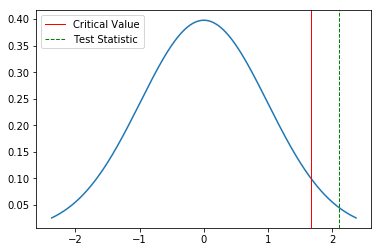

In [64]:
plot_hypo_t(0, t, t_alpha)

Test statistic $t$ falls into the rejection region $t=2.0995 > t_{\alpha} = 1.6632$.

$pvalue = 0.0194 < \alpha = 0.05$

Therefore, we reject the null hypothesis $H_0$. There is enough evidence to suggest that students who do not consume alcohol or consume very little get better grades than students who consume more than very little of alcohol per week at 5% significance level.